# Testing batdetect2 pipeline features:

## **Working on features relevant to the use of this pipeline on recovered Audiomoth .wav recordings**

## 1) Figuring out our imports:

### a) Below are the imports pertaining to accessing data and metadata

In [1]:
from pathlib import Path
import exiftool
import glob

### b) Below are the imports pertaining to data manipulation

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

### c) Below are the imports pertaining to data visualization

In [3]:
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime as dt

### d) Below are the imports pertaining to the use of the MSDS pipeline

In [4]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline

## 2) Initializing our required variables:

### a) Below we initialize our input/output directories and output pipeline csv name

In [5]:
dirpath = f"{Path.home()}/Documents/Research/Symposium/Recordings/recover-20220828/UBNA_010"

recover_folder = dirpath.split('/')[-2]
recover_date = recover_folder.split('-')[1]
audiomoth_folder = dirpath.split('/')[-1]
audiomoth_unit = audiomoth_folder.split('_')[-1]

### b) Below we initialize our field records depending on what year our data is from to gather the site name

In [6]:
if str(dt.datetime.strptime(recover_date, "%Y%m%d").year) == "2022":
    field_records = batdetect2_pipeline.get_field_records(Path(f"../field_records/ubna_2022b.csv"))
if str(dt.datetime.strptime(recover_date, "%Y%m%d").year) == "2023":
    field_records = batdetect2_pipeline.get_field_records(Path(f"../field_records/ubna_2023.csv"))

site_name = batdetect2_pipeline.get_site_name(field_records, recover_date, audiomoth_unit)
site_name

'Central Pond'

In [7]:
save_dir = f'../output_dir/{recover_folder}/{site_name}'
detfile_name = f'batdetect2_pipeline__{recover_folder}_{audiomoth_folder}'

[dirpath, save_dir, detfile_name]

['/Users/adityakrishna/Documents/Research/Symposium/Recordings/recover-20220828/UBNA_010',
 '../output_dir/recover-20220828/Central Pond',
 'batdetect2_pipeline__recover-20220828_UBNA_010']

## 3) Test any main pipeline functions using the initialized variables

### a) Below we test-run our pipeline using the main `run_pipeline()` command in `src/batdt2_pipeline.py`

In [8]:
# batdetect2_pipeline.run_pipeline(dirpath, f"{detfile_name}.csv", save_dir, "../output/tmp", True, False)

### b) Below is the function that will be used in our pipeline to plot the activity plots; Use it to test the overall function

In [9]:
# batdetect2_pipeline.plot_dets_as_activity_grid(dirpath, f"{detfile_name}.csv", save_dir, site_name, show_PST=True, save=False)

## 4) Develop any of the main functions below:

### a) Below is the code for plotting activity; it has been developed to include:

- PST functionality with axis labels for UTC/PST
- Plotting site name in title of activity
- Aligning ticks and grid lines to feel intuitive
- Masking values that are 0 implying there was an error collecting that time's recording

There are 21 audio files that passed 1st level of filtering!
There are 21 audio files that passed 2nd level of filtering!


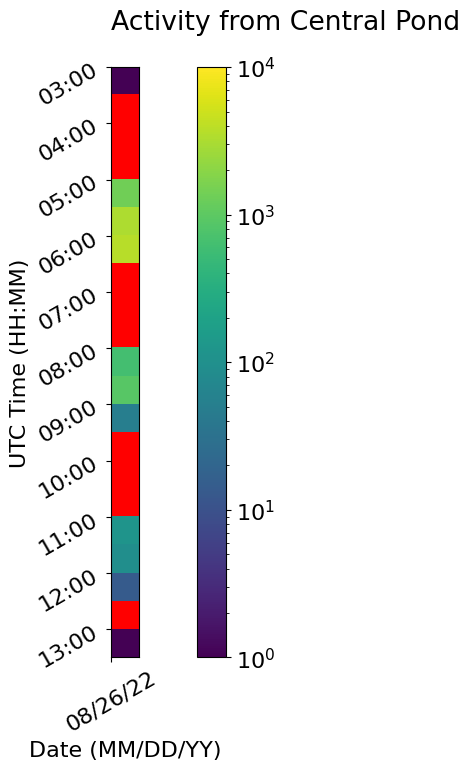

In [10]:
recover_folder = dirpath.split('/')[-2]
audiomoth_folder = dirpath.split('/')[-1]
dets = pd.read_csv(f'{save_dir}/{detfile_name}.csv')
activity = np.array([])
show_PST = False
activity_times = []
activity_dates = []

start_time, end_time = batdetect2_pipeline.get_recording_period(dirpath)
dates = batdetect2_pipeline.get_dates_of_deployment(dirpath)
ref_audio_files = batdetect2_pipeline.get_files_to_reference(dirpath, dates, start_time, end_time)
good_audio_files = batdetect2_pipeline.get_files_for_pipeline(ref_audio_files)

for file in good_audio_files:
    filedets = dets.loc[dets['input_file']==Path(file).name]
    activity = np.hstack([activity, len(filedets)+1])

    file_dt_UTC = dt.datetime.strptime(Path(file).name, "%Y%m%d_%H%M%S.WAV")

    if show_PST:
        if (file_dt_UTC.hour >= 7):
            file_dt_PST = dt.datetime.strptime(f"{file_dt_UTC.date()}_{str(file_dt_UTC.hour - 7).zfill(2)}{file_dt_UTC.minute}", "%Y-%m-%d_%H%M")
            file_time_PST = dt.datetime.strftime(file_dt_PST, "%H:%M")
        else:
            file_dt_PST = dt.datetime.strptime(f"{file_dt_UTC.date()}_{str(24 + file_dt_UTC.hour - 7).zfill(2)}{file_dt_UTC.minute}", "%Y-%m-%d_%H%M")
            file_time_PST = dt.datetime.strftime(file_dt_PST, "%H:%M")
        if (not(activity_times.__contains__(file_time_PST))):
            activity_times.append(file_time_PST)
    else:
        file_time_UTC = dt.datetime.strftime(file_dt_UTC, "%H:%M")
        if (not(activity_times.__contains__(file_time_UTC))):
            activity_times.append(file_time_UTC)

    file_date = dt.datetime.strftime(file_dt_UTC, "%m/%d/%y")
    if (not(activity_dates.__contains__(file_date))):
        activity_dates.append(file_date)

activity = activity.reshape((len(activity_dates), len(activity_times))).T

activity[1:-1:6] = 0
activity[2:-1:6] = 0
activity[3:-1:6] = 0

masked_array_for_nodets = np.ma.masked_where(activity==0, activity)
cmap = plt.get_cmap('viridis')
cmap.set_bad(color='red', alpha=1.0)

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12, 8))
plt.title(f"Activity from {site_name}", loc='left', y=1.05)
plt.imshow(masked_array_for_nodets, cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=10e3))
plt.yticks(np.arange(0, len(activity_times), 2)-0.5, activity_times[::2], rotation=30)
plt.xticks(np.arange(0, len(activity_dates))-0.5, activity_dates, rotation=30)
plt.ylabel('UTC Time (HH:MM)')
plt.xlabel('Date (MM/DD/YY)')
plt.colorbar()
plt.tight_layout()
plt.show()

### b) Below is the code for using exiftool to skip error files in our pipeline

- Starting to learn how to use exiftool or PyExifTool 
- Implementing checks for error files using Audiomoth .wav metadata
- Incorporating checks into generate_segments() function so pipeline only generates segments for valid recordings

#### Initialize the set of test files we need to analyze

- Some of them will be error files
- Some of them will be usable files

In [11]:
dirpath = f"{Path.home()}/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001"
start_time, end_time = batdetect2_pipeline.get_recording_period(dirpath)
dates = batdetect2_pipeline.get_dates_of_deployment(dirpath)
files = batdetect2_pipeline.get_files_to_reference(dirpath, dates, start_time, end_time)
files

[PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_030000.WAV'),
 PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_053000.WAV'),
 PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_060000.WAV'),
 PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_063000.WAV'),
 PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_073000.WAV'),
 PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_090000.WAV')]

#### Print the metadata of a single Audiomoth recording

In [12]:
exiftool.ExifToolHelper().get_metadata(files)[4]

{'SourceFile': '/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_073000.WAV',
 'ExifTool:ExifToolVersion': 12.63,
 'File:FileName': '20230610_073000.WAV',
 'File:Directory': '/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001',
 'File:FileSize': 689280488,
 'File:FileModifyDate': '2023:06:10 00:59:54-07:00',
 'File:FileAccessDate': '2023:06:26 07:36:00-07:00',
 'File:FileInodeChangeDate': '2023:06:26 07:36:00-07:00',
 'File:FilePermissions': 100644,
 'File:FileType': 'WAV',
 'File:FileTypeExtension': 'WAV',
 'File:MIMEType': 'audio/x-wav',
 'RIFF:Encoding': 1,
 'RIFF:NumChannels': 1,
 'RIFF:SampleRate': 192000,
 'RIFF:AvgBytesPerSec': 384000,
 'RIFF:BitsPerSample': 16,
 'RIFF:Comment': 'Recorded at 07:30:00 10/06/2023 (UTC) by AudioMoth 24F319055FDF2F5B at medium gain while battery was 4.0V and temperature was 13.6C.',
 'RIFF:Artist': 'AudioMoth 24F319055FD

The RIFF:Comment tag seems important and unique to each error file.

- 488-byte ones say the recording was stopped because of microphone change.
- Standard size ones with unusable data say the recording was made using an external microphone.
- Standard size ones with usuable data have no mention of a microphone.

#### So let's look for NO mention of a "mircophone" in the RIFF:Comment and filter our files based on this.

In [13]:
good_files=[]
comments = exiftool.ExifToolHelper().get_tags(files, tags='RIFF:Comment')
df_comments = pd.DataFrame(comments)
good_files = df_comments.loc[~df_comments['RIFF:Comment'].str.contains("microphone")]['SourceFile'].values
good_files

array(['/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_073000.WAV',
       '/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_090000.WAV'],
      dtype=object)

#### Our filter worked and our pipeline ran on the good_files of `recover-20230616/UBNA_001` with no error

### Now we need to make changes in our plotting to plot data generated from error sessions

#### 1) Import `recover-20230616_UBNA_001 detections

In [14]:
dirpath = f"{Path.home()}/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001"

recover_folder = dirpath.split('/')[-2]
recover_date = recover_folder.split('-')[1]
audiomoth_folder = dirpath.split('/')[-1]
audiomoth_unit = audiomoth_folder.split('_')[-1]

if str(dt.datetime.strptime(recover_date, "%Y%m%d").year) == "2022":
    field_records = batdetect2_pipeline.get_field_records(Path(f"../field_records/ubna_2022b.csv"))
if str(dt.datetime.strptime(recover_date, "%Y%m%d").year) == "2023":
    field_records = batdetect2_pipeline.get_field_records(Path(f"../field_records/ubna_2023.csv"))

site_name = batdetect2_pipeline.get_site_name(field_records, recover_date, audiomoth_unit)

save_dir = f'../output_dir/{recover_folder}/{site_name}'
detfile_name = f'bd2__{recover_folder}_{audiomoth_folder}'

[dirpath, save_dir, detfile_name]

['/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001',
 '../output_dir/recover-20230616/Foliage',
 'bd2__recover-20230616_UBNA_001']

In [15]:
dets = pd.read_csv(f'{save_dir}/{detfile_name}.csv')
dets

,start_time,end_time,low_freq,high_freq,detection_confidence,event,input_file
0,550.2155,550.2263,44375.0,52219.0,0.535,Echolocation,20230610_073000.WAV
1,551.2365,551.2458,43515.0,58293.0,0.503,Echolocation,20230610_073000.WAV
2,551.3975,551.4069,42656.0,64373.0,0.576,Echolocation,20230610_073000.WAV
3,551.4845,551.4939,42656.0,60371.0,0.505,Echolocation,20230610_073000.WAV
4,551.5725,551.5828,42656.0,67232.0,0.589,Echolocation,20230610_073000.WAV
...,...,...,...,...,...,...,...
33637,1720.3845,1720.3935,45234.0,57293.0,0.571,Echolocation,20230615_053000.WAV
33638,1720.5645,1720.5743,46093.0,53594.0,0.582,Echolocation,20230615_053000.WAV
33639,1720.7535,1720.7619,45234.0,55072.0,0.569,Echolocation,20230615_053000.WAV
33640,1720.9335,1720.9405,46093.0,60479.0,0.628,Echolocation,20230615_053000.WAV


### For distinguishing files with 0 dets and files that have error, we created 2 sets:
- 1 for the audio files representative of the times the Audiomoth was ON.
- 1 for the audio files representative of the times that the batdetect2 pipeline can run on (i.e. have no error)

In [16]:
activity = np.array([])
activity_times = []
activity_dates = []
start_time, end_time = batdetect2_pipeline.get_recording_period(dirpath)
dates = batdetect2_pipeline.get_dates_of_deployment(dirpath)
ref_audio_files = batdetect2_pipeline.get_files_to_reference(dirpath, dates, start_time, end_time)
good_audio_files = batdetect2_pipeline.get_files_for_pipeline(ref_audio_files)

[good_audio_files, ref_audio_files]

There are 6 audio files that passed 1st level of filtering!
There are 2 audio files that passed 2nd level of filtering!


[array([PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_073000.WAV'),
        PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_090000.WAV')],
       dtype=object),
 [PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_030000.WAV'),
  PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_053000.WAV'),
  PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_060000.WAV'),
  PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_063000.WAV'),
  PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_seas

#### In our activity matrices:
- If the reference file is a good audio file, we store the grid value as the number of detections + 1
- If the reference fule is not a good audio file, we store the grid value as 0.

#### By masking all 0 values with red, our matrices show red when there has been an error recording data for the time.

In [17]:
for file in ref_audio_files:
    filedets = dets.loc[dets['input_file']==(file).name]
    if file in good_audio_files:
        activity = np.hstack([activity, len(filedets) + 1])
    else:
        activity = np.hstack([activity, 0])

activity

array([ 0.,  0.,  0.,  0., 24.,  1.])

### c) Need to rework `get_files_for_pipeline()` and `get_files_to_reference()` to use `CONFIG.TXT`

In [18]:
config_path = f'{dirpath}/CONFIG.TXT'
config_details = pd.read_csv(config_path, header=0, index_col=0, sep=" : ", engine='python').transpose()
config_details.columns = config_details.columns.str.strip()
recording_period = config_details['Recording period 1'].values[0]
period_tokens = recording_period.split(' ')
config_details

Device ID,Firmware,Time zone,Sample rate (Hz),Gain,Sleep duration (s),Recording duration (s),Active recording periods,Recording period 1,Earliest recording time,Latest recording time,...,Enable LED,Enable low-voltage cut-off,Enable battery level indication,Always require acoustic chime,Use daily folder for WAV files,Disable 48Hz DC blocking filter,Enable energy saver mode,Enable low gain range,Enable magnetic switch,Enable GPS time setting
24F319055FDF2F5B,AudioMoth-Firmware-Basic (1.8.1),UTC,192000,Medium,5,1795,1,03:00 - 13:30 (UTC),---------- --:--:--,---------- --:--:--,...,Yes,Yes,Yes,No,No,No,No,No,No,No


In [19]:
start_time, end_time = batdetect2_pipeline.get_recording_period(dirpath)
dates = batdetect2_pipeline.get_dates_of_deployment(dirpath)
ref_audio_files = batdetect2_pipeline.get_files_to_reference(dirpath, dates, start_time, end_time)

In [20]:
good_audio_files = batdetect2_pipeline.get_files_for_pipeline(ref_audio_files)

There are 6 audio files that passed 1st level of filtering!
There are 2 audio files that passed 2nd level of filtering!


### d) Using `dask.dataframe` to concatenate all generated detections into 1 large `pandas.dataframe`.

In [21]:
def construct_cumulative_activity(site, resample_tag):
    new_df = dd.read_csv(f"../output_dir/recover-2023*/{site}/activity__*.csv").compute()
    new_df["date_and_time_UTC"] = pd.to_datetime(new_df["date_and_time_UTC"], format="%Y-%m-%d %H:%M:%S")
    new_df.pop(new_df.columns[0])
    new_df = new_df.replace(0, -1)

    resampled_df = new_df.resample(resample_tag, on="date_and_time_UTC").sum()
    selected_time_df = resampled_df.replace(0, np.nan)
    selected_time_df = selected_time_df.dropna()
    selected_time_df = selected_time_df.replace(-1, 0)

    dt_hourmin_info = sorted(list(set((selected_time_df.index).strftime("%H:%M"))))
    dates = (pd.date_range(selected_time_df.index[0], selected_time_df.index[-1], freq="D")).strftime("%m-%d-%y")
    activity = (selected_time_df["num_of_detections"].values).reshape(len(dates), len(dt_hourmin_info)).T

    activity_df = pd.DataFrame(activity, index=dt_hourmin_info, columns=dates)
    activity_df.to_csv(f'../output_dir/cumulative_plots/cumulative_activity__{site.split()[0]}_{resample_tag}.csv')

    return activity_df

In [22]:
def plot_cumulative_activity(activity_df, site, resample_tag):
    masked_array_for_nodets = np.ma.masked_where(activity_df.values==0, activity_df.values)
    cmap = plt.get_cmap('viridis')
    cmap.set_bad(color='red')

    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(24, 10))
    plt.title(f"Activity from {site}", loc='center', y=1.05)
    plt.imshow(masked_array_for_nodets, cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=10e3))
    plt.yticks(np.arange(0, len(activity_df.index))-0.5, activity_df.index, rotation=45)
    plt.xticks(np.arange(0, len(activity_df.columns))-0.5, activity_df.columns, rotation=45)
    plt.ylabel('UTC Time (HH:MM)')
    plt.xlabel('Date (MM-DD-YY)')
    plt.colorbar()
    plt.tight_layout()

    plt.savefig(f'../output_dir/cumulative_plots/cumulative_activity__{site.split()[0]}_{resample_tag}.png')
    plt.show()

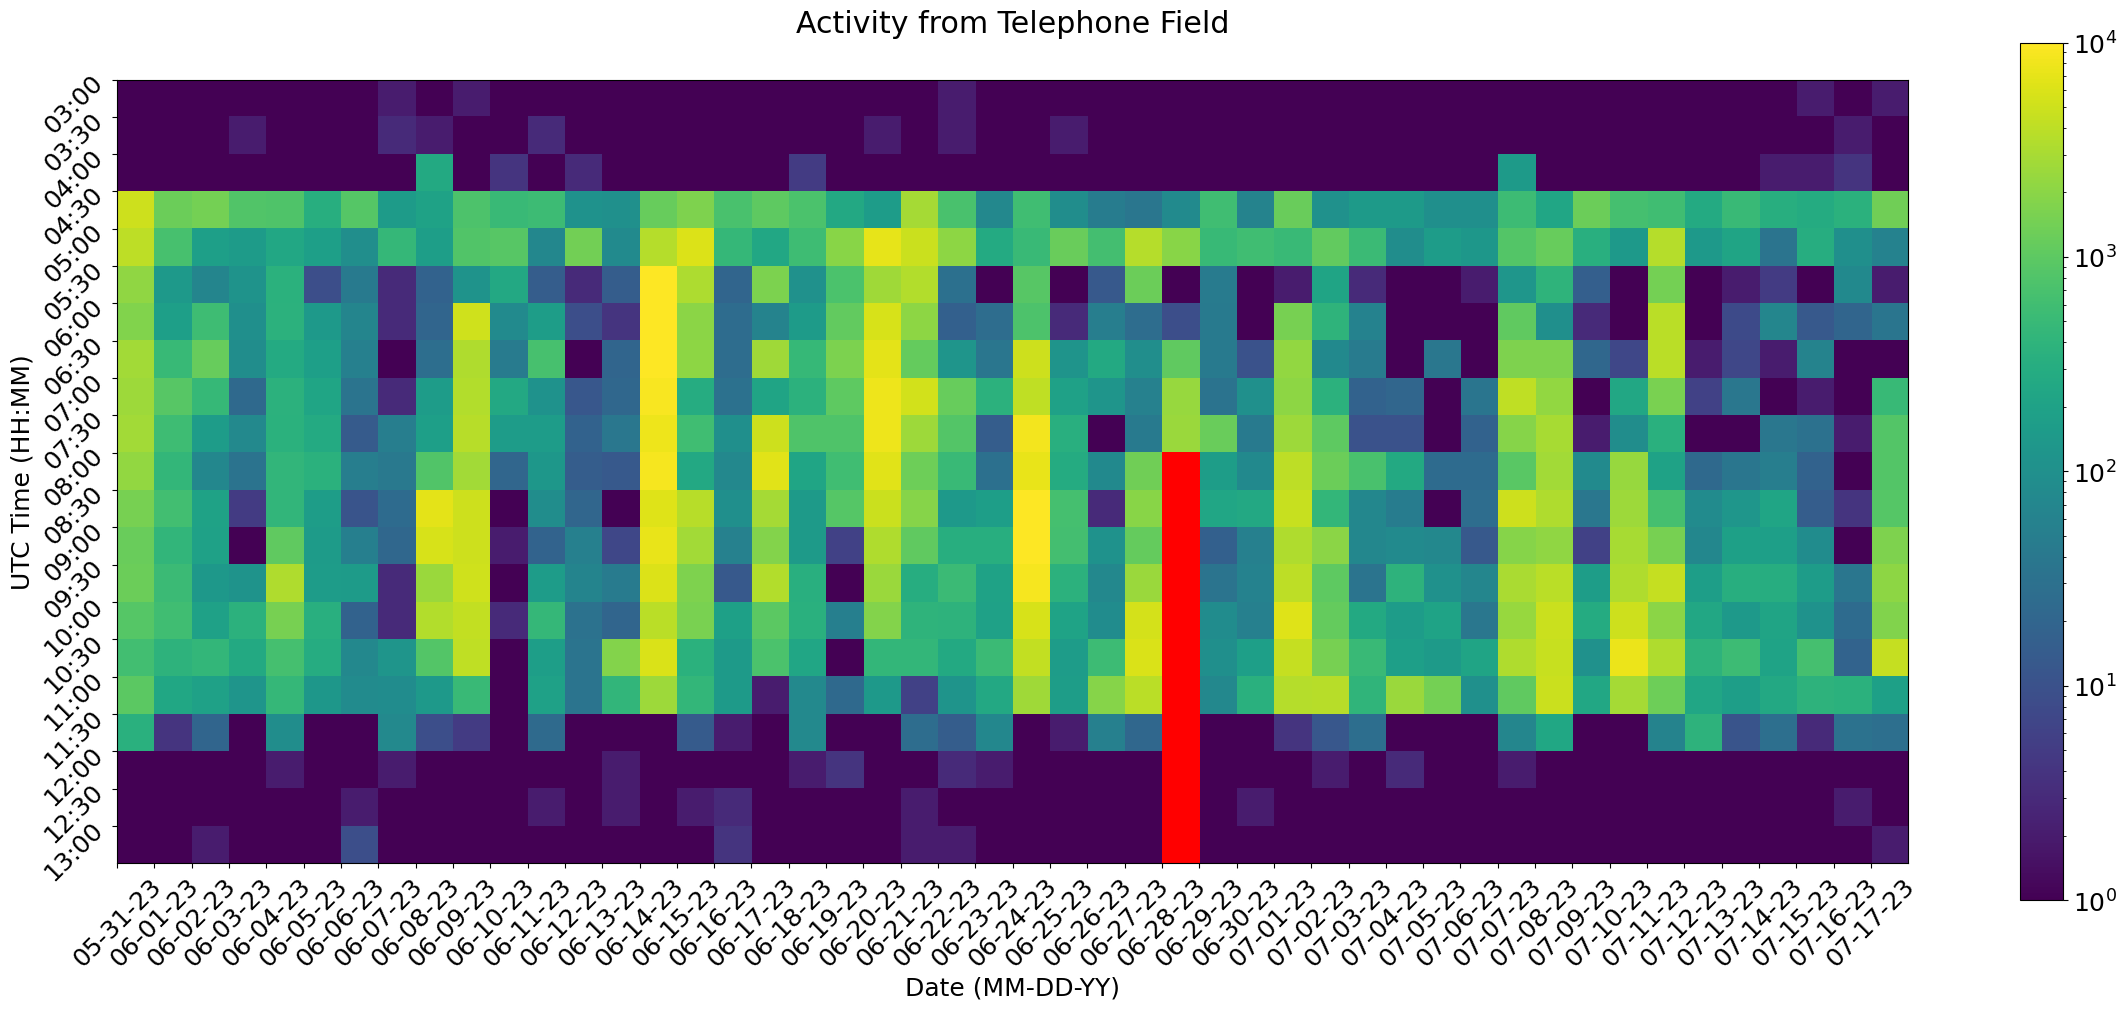

In [23]:
site = "Telephone Field"
resample_tag = "30T"

activity_df = construct_cumulative_activity(site, resample_tag)
plot_cumulative_activity(activity_df, site, resample_tag)


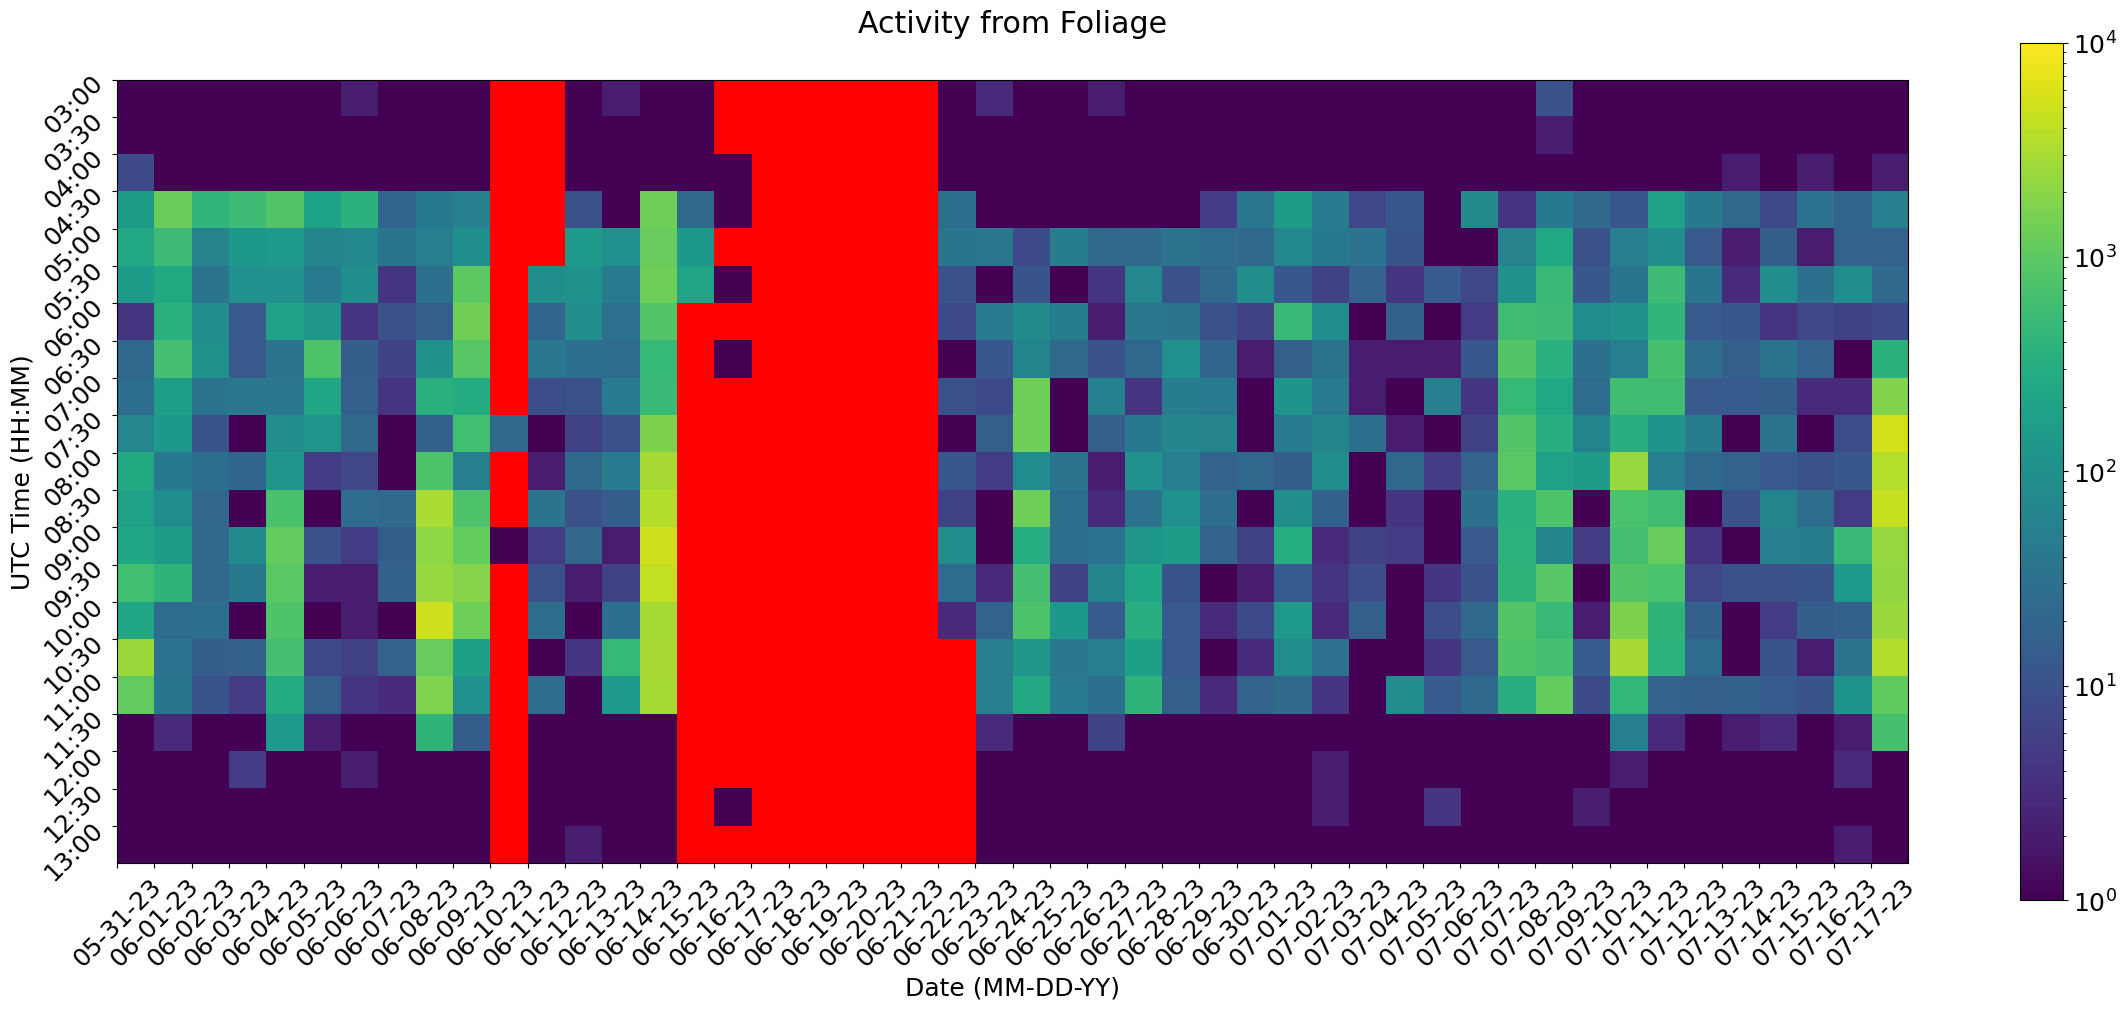

In [24]:
site = "Foliage"
resample_tag = "30T"

activity_df = construct_cumulative_activity(site, resample_tag)
plot_cumulative_activity(activity_df, site, resample_tag)

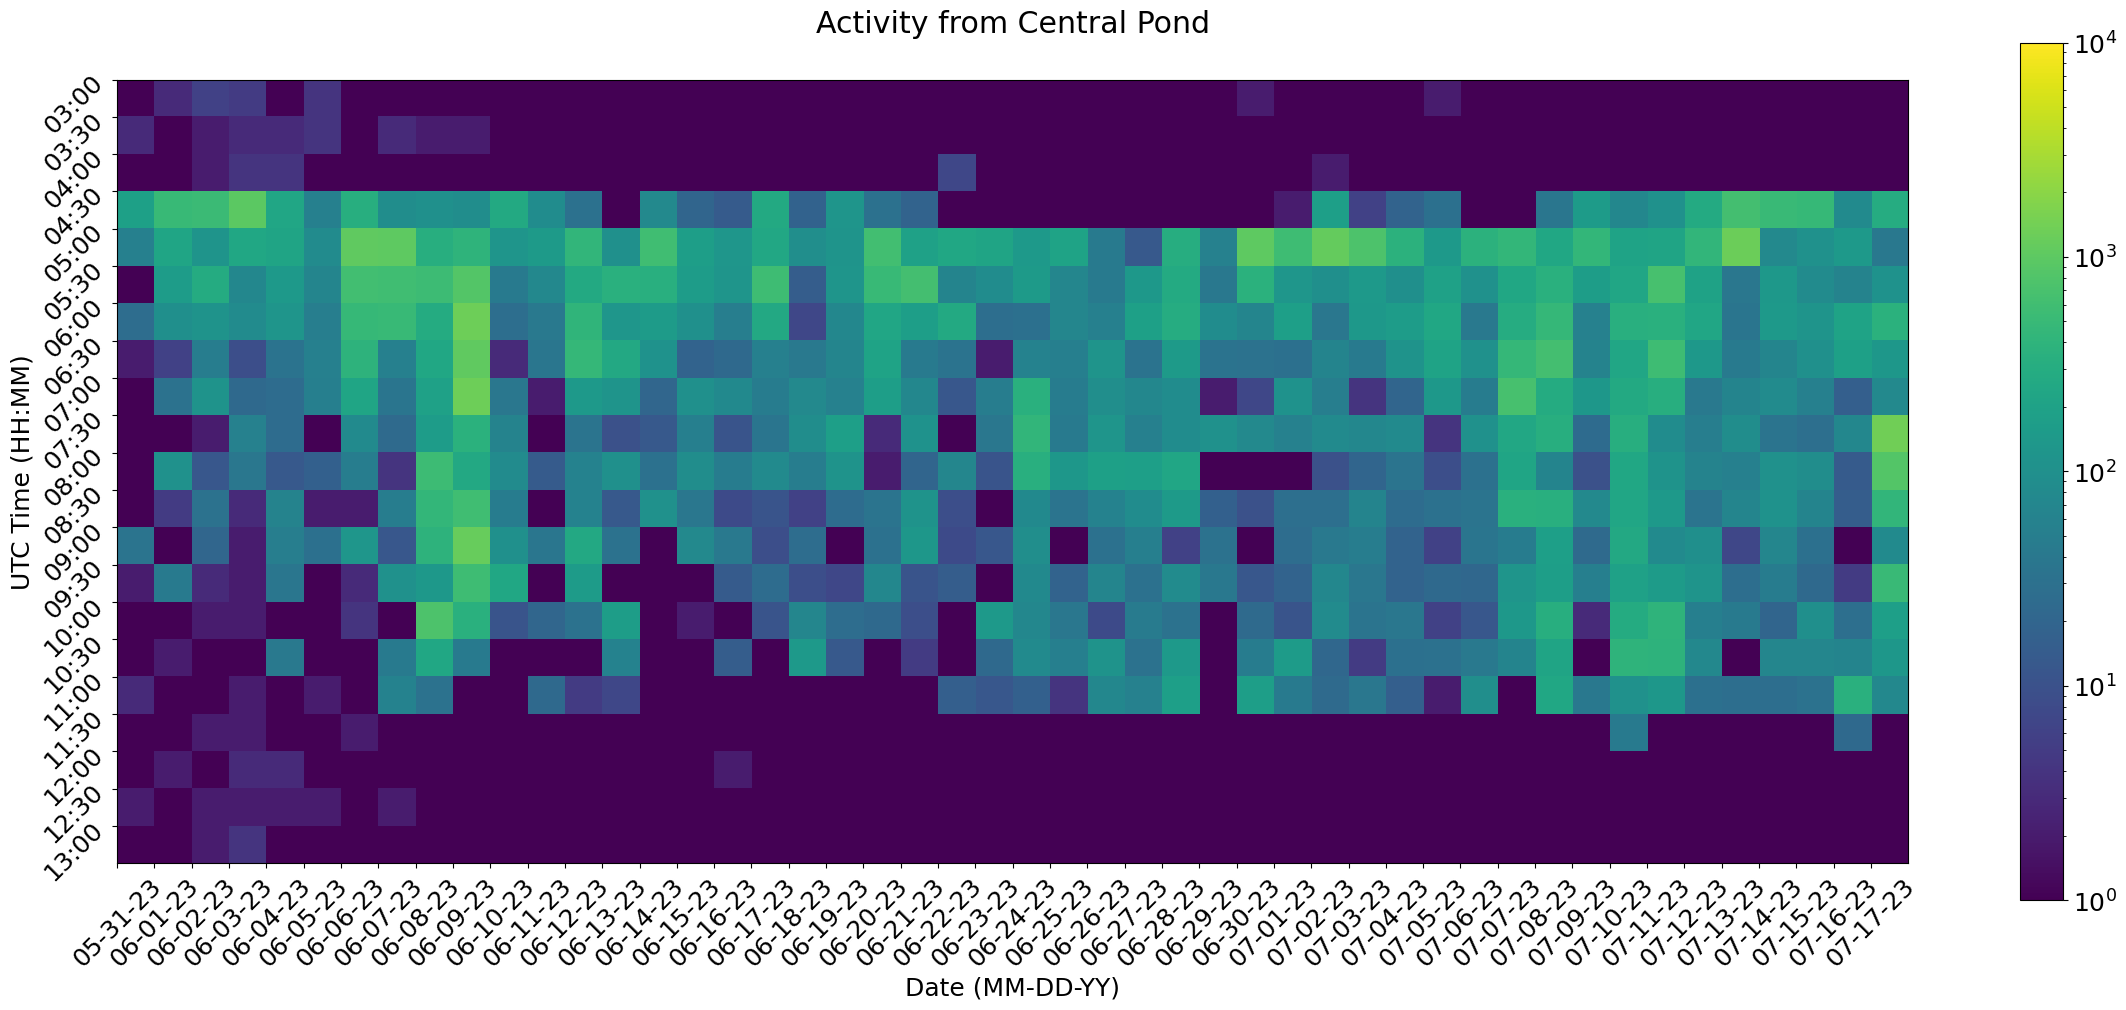

In [25]:
site = "Central Pond"
resample_tag = "30T"

activity_df = construct_cumulative_activity(site, resample_tag)
plot_cumulative_activity(activity_df, site, resample_tag)